<a href="https://colab.research.google.com/github/Sanim27/Mnist_NN/blob/main/deepNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [249]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [250]:
%matplotlib inline

In [251]:
dataset=MNIST(root='data/',download=True,transform=ToTensor())

image shape:  torch.Size([1, 28, 28])
Label: 5


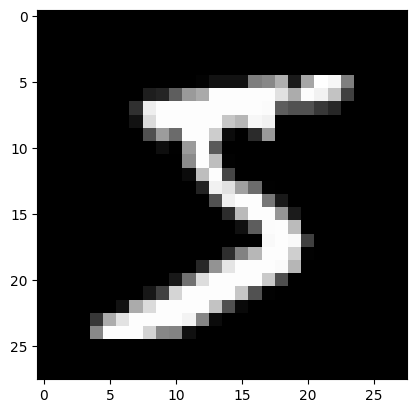

In [252]:
image,label=dataset[0]
print('image shape: ',image.shape)
plt.imshow(image.permute(1,2,0),cmap='gray')
print('Label:',label)
plt.show()

In [253]:
len(dataset)

60000

Permute is done for changing dimensions to (28x28x1)

In [254]:
image.shape
image.permute(1,2,0).shape

torch.Size([28, 28, 1])

In [255]:
val_size=10000
train_size=50000
train_ds,val_ds=random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)

(50000, 10000)

In [256]:
batch_size=128

In [257]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


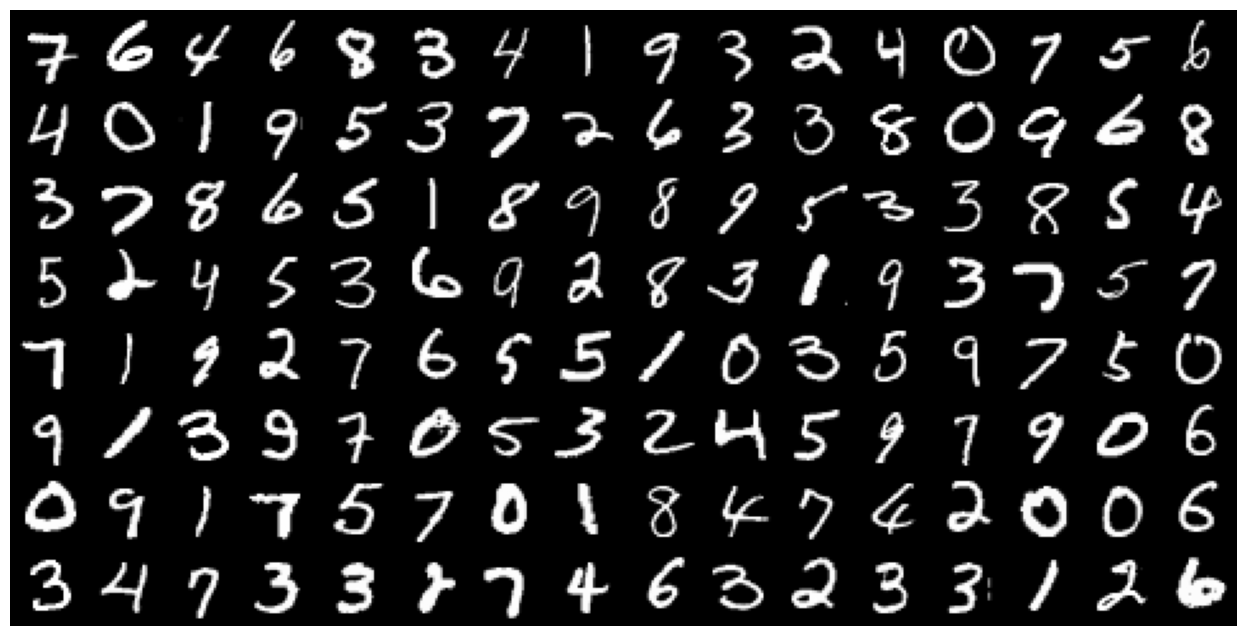

In [258]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [259]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [260]:
input_size = inputs.shape[-1]
hidden_size = 32

In [261]:
layer1 = nn.Linear(input_size, hidden_size)

In [262]:
inputs.shape

torch.Size([128, 784])

In [263]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


In [264]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [265]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [266]:
relu_outputs = F.relu(layer1_outputs)

In [267]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [268]:
inputs.shape

torch.Size([128, 784])

In [269]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.2986, grad_fn=<NllLossBackward0>)

In [270]:
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [271]:
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [272]:
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [273]:
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [274]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracyy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [275]:
def accuracyy(outputs,labels):
  _,preds=torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [276]:
input_size=784
hidden_units=32
output_size=10

In [277]:
model=MnistModel(input_size,hidden_units,output_size)

In [278]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [279]:
for images,labels in train_loader:
  outputs=model(images)
  loss=F.cross_entropy(outputs,labels)
  print(loss.item())
  break
print('outputs shape',outputs.shape)
print('sample outputs',outputs[:2].data)

2.3010787963867188
outputs shape torch.Size([128, 10])
sample outputs tensor([[-0.0233, -0.0740, -0.1171, -0.2007, -0.1891,  0.1707,  0.1593,  0.0946,
          0.0091, -0.1611],
        [ 0.1284, -0.0989,  0.0056, -0.1896, -0.0506,  0.1828,  0.1949,  0.0087,
          0.0767, -0.0880]])


In [280]:
cuda_available = torch.cuda.is_available()

print(f"CUDA available: {cuda_available}")

CUDA available: False


In [281]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [282]:
device=get_default_device()
device

device(type='cpu')

In [283]:
def to_device(data,device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device,non_blocking=True)

In [284]:
for images,labels in train_loader:
  print(images.shape)
  print(images.device)
  images=to_device(images,device)
  print(images.device)
  break

torch.Size([128, 1, 28, 28])
cpu
cpu


In [285]:
class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)
  def __len__(self):
    return len(self.dl)

In [286]:
train_loader=DeviceDataLoader(train_loader,device)
val_loader=DeviceDataLoader(val_loader,device)

In [287]:
for xb,yb in val_loader:
  print('xb.device:',xb.device)
  print('yb:',yb)
  break

xb.device: cpu
yb: tensor([4, 5, 1, 7, 2, 1, 7, 5, 8, 4, 4, 1, 9, 7, 7, 5, 0, 1, 0, 1, 3, 7, 7, 1,
        2, 5, 0, 3, 3, 8, 6, 5, 3, 3, 6, 1, 8, 9, 5, 4, 8, 6, 5, 7, 6, 5, 6, 8,
        4, 1, 3, 8, 9, 0, 9, 7, 6, 1, 4, 3, 7, 2, 5, 4, 7, 3, 7, 3, 8, 1, 4, 9,
        5, 3, 2, 5, 7, 1, 4, 6, 9, 9, 6, 5, 9, 6, 4, 1, 6, 3, 2, 3, 0, 4, 2, 8,
        0, 0, 5, 1, 4, 9, 0, 4, 8, 3, 2, 3, 5, 8, 3, 2, 3, 8, 8, 3, 7, 1, 8, 6,
        9, 5, 5, 2, 0, 5, 1, 7, 9, 1, 0, 4, 9, 6, 8, 3, 8, 1, 2, 6, 9, 7, 3, 0,
        3, 9, 2, 5, 2, 7, 0, 9, 1, 5, 7, 0, 0, 4, 4, 6, 3, 7, 1, 1, 6, 4, 3, 0,
        6, 7, 4, 2, 2, 7, 3, 8, 4, 6, 6, 3, 1, 7, 1, 0, 4, 2, 6, 7, 1, 5, 6, 5,
        8, 0, 4, 9, 3, 5, 2, 0, 8, 0, 1, 8, 3, 9, 4, 7, 6, 2, 0, 8, 0, 3, 1, 1,
        1, 6, 8, 8, 9, 8, 9, 0, 1, 6, 3, 5, 5, 2, 5, 6, 6, 5, 8, 5, 8, 9, 3, 7,
        0, 5, 5, 1, 5, 3, 9, 2, 6, 4, 5, 9, 3, 0, 1, 5])


In [288]:
train_loader.__len__()

391

In [289]:
def fit(epochs,lr,model,train_loader,val_loader,opt_func=torch.optim.Adam):
  History=[]
  optimizer=opt_func(model.parameters(),lr)
  for epoch in range(epochs):
    for batch in train_loader:
      #training
      loss=model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    #validation
    result=evaluate(model,val_loader)
    History.append(result)
    model.epoch_end(epoch,result)
  return History

def evaluate(model,val_loader):
  outputs=[model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [290]:
model=MnistModel(input_size,hidden_size=hidden_units,out_size=output_size)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [291]:
history=[evaluate(model,val_loader)]
history

[{'val_loss': 2.3078722953796387, 'val_acc': 0.09189452975988388}]

In [292]:
history0=fit(5,0.0001,model,train_loader,val_loader)

Epoch [0], val_loss: 1.1693, val_acc: 0.8044
Epoch [1], val_loss: 0.6939, val_acc: 0.8575
Epoch [2], val_loss: 0.5253, val_acc: 0.8789
Epoch [3], val_loss: 0.4457, val_acc: 0.8885
Epoch [4], val_loss: 0.3991, val_acc: 0.8960


In [293]:
history1=fit(5,0.0001,model,train_loader,val_loader)

Epoch [0], val_loss: 0.3656, val_acc: 0.9021
Epoch [1], val_loss: 0.3432, val_acc: 0.9065
Epoch [2], val_loss: 0.3286, val_acc: 0.9090
Epoch [3], val_loss: 0.3163, val_acc: 0.9126
Epoch [4], val_loss: 0.3075, val_acc: 0.9159


In [294]:
history2=fit(5,0.0001,model,train_loader,val_loader)

Epoch [0], val_loss: 0.2979, val_acc: 0.9187
Epoch [1], val_loss: 0.2910, val_acc: 0.9215
Epoch [2], val_loss: 0.2837, val_acc: 0.9227
Epoch [3], val_loss: 0.2782, val_acc: 0.9244
Epoch [4], val_loss: 0.2728, val_acc: 0.9248


In [295]:
history3=fit(5,0.001,model,train_loader,val_loader)

Epoch [0], val_loss: 0.2365, val_acc: 0.9347
Epoch [1], val_loss: 0.2107, val_acc: 0.9418
Epoch [2], val_loss: 0.1901, val_acc: 0.9460
Epoch [3], val_loss: 0.1760, val_acc: 0.9496
Epoch [4], val_loss: 0.1674, val_acc: 0.9509


In [296]:
history4=fit(5,0.001,model,train_loader,val_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], val_loss: 0.1577, val_acc: 0.9541
Epoch [1], val_loss: 0.1550, val_acc: 0.9546
Epoch [2], val_loss: 0.1456, val_acc: 0.9578
Epoch [3], val_loss: 0.1434, val_acc: 0.9568
Epoch [4], val_loss: 0.1400, val_acc: 0.9569


In [297]:
history=history1+history2+history3+history4

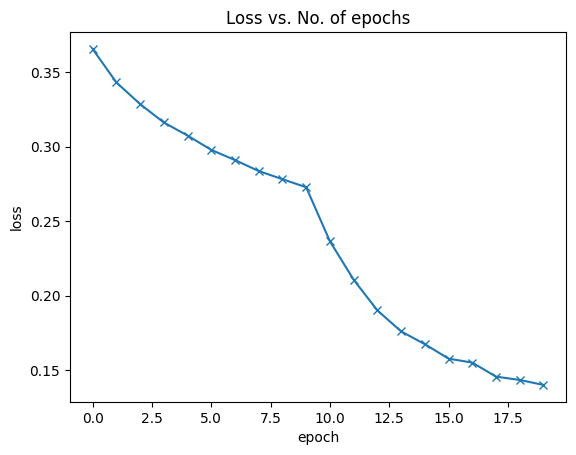

In [298]:
losses=[x['val_loss'] for x in history]
plt.plot(losses,'-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

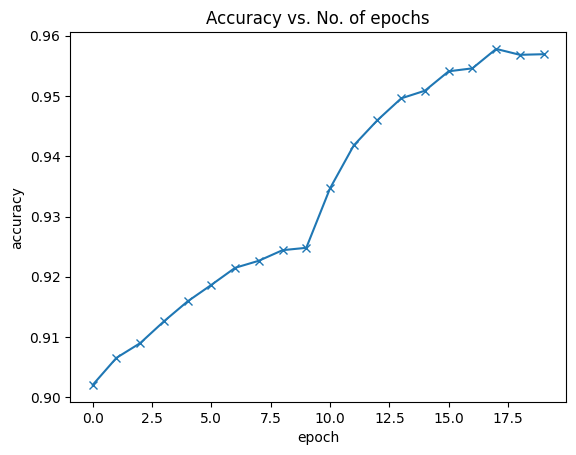

In [299]:
accuracy=[x['val_acc'] for x in history]
plt.plot(accuracy,'-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [300]:
test_dataset=MNIST(root='data/',train=False,transform=ToTensor())

In [301]:
def predict_image(img,model):
  xb=to_device(img.unsqueeze(0),device)
  yb=model(xb)
  _,preds=torch.max(yb,dim=1)
  return preds[0].item()

Label: 7 , Predicted: 7


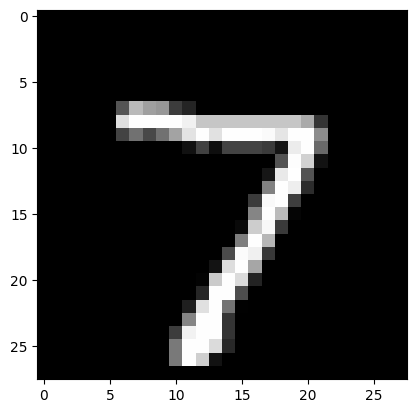

In [302]:
img,label=test_dataset[0]
plt.imshow(img[0],cmap='gray')
print('Label:',label, ', Predicted:',predict_image(img,model))

Label: 3 , Predicted: 3


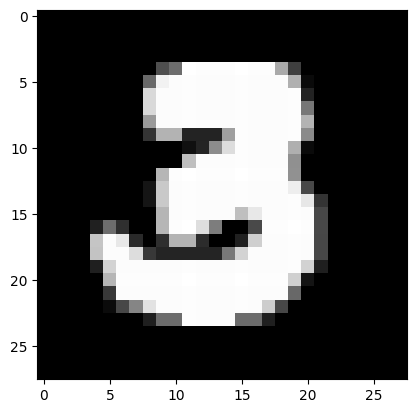

In [303]:
img,label=test_dataset[200]
plt.imshow(img[0],cmap='gray')
print('Label:',label, ', Predicted:',predict_image(img,model))

Label: 2 , Predicted: 2


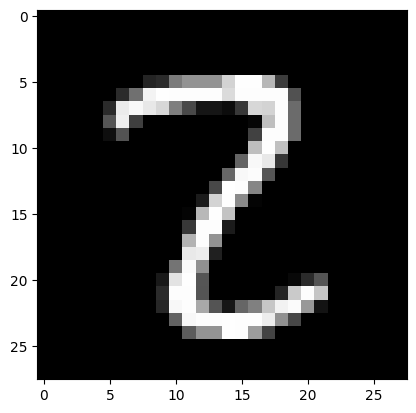

In [304]:
img,label=test_dataset[1839]
plt.imshow(img[0],cmap='gray')
print('Label:',label, ', Predicted:',predict_image(img,model))

Label: 9 , Predicted: 9


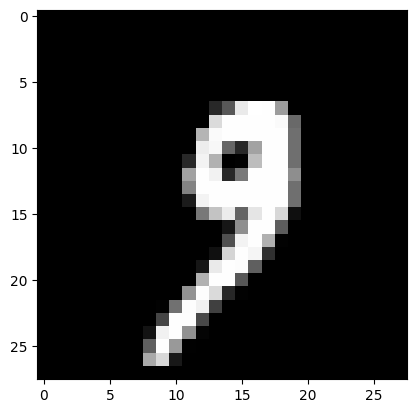

In [305]:
img,label=test_dataset[1000]
plt.imshow(img[0],cmap='gray')
print('Label:',label, ', Predicted:',predict_image(img,model))

In [307]:
test_loader=DeviceDataLoader(DataLoader(test_dataset,batch_size*2),device)
result=evaluate(model,test_loader)
result

{'val_loss': 0.12275250256061554, 'val_acc': 0.96484375}